---

Universidade Federal do Rio Grande do Norte

Centro de Tecnologia

Departamento de Engenharia de Computação e Automação

DCA0131 - Ciência de Dados

Discentes: 

- Levy Gabriel da Silva Galvão
- Thiago Maia Souto
- Vinícius Albuquerque Malafaya

Título: **Análise exploratória de dados abertos da UFRN para apresentação de indicadores para tomadas de decisões administrativas**

---

In [48]:
# Bilbiotecas necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import re 
from google.colab import files

# 1. Introdução

Neste *notebook* serão desenvolvidas análises exploratórias de dados buscando determinar as disciplinas/docentes que mais reprovam e procurar traçar um conjunto de horários para estabelecer plantões de monitoria para uma disciplina qualquer na lista de componentes curriculares presenciais da UFRN.

Consideram-se os melhores horários para o plantão de monitoria da disciplina $X$ aqueles que possuem a maior probabilidade de que os discentes matriculados na disciplina $X$ estejam livres, ou pelo menos sem horário de aula. Também as disciplinas que mais reprovam contribuem para a necessidade de uma monitoria.

Dessa forma serão usados quatro conjuntos de dados disponibilizados pelo programa de [Dados Abertos da UFRN](http://dados.ufrn.br/), estes são:

- [Componentes Curriculares Presenciais](http://dados.ufrn.br/dataset/componentes-curriculares/resource/9a3521d2-4bc5-4fda-93f0-f701c8a20727): o interesse nesse conjunto de dados é relacionar o **nome** ou **código da disciplina** com o **ID de componente** que determina o nome da disciplina e seu código;
- [Turmas](http://dados.ufrn.br/dataset/turmas): esse conjunto de dados permitirá relacionar as **IDs de componente** obtidas no conjunto de dados anterior com o **ID de turma** que indicará quais componentes curriculares possuem turmas abertas;
- [Matrículas em Componentes](http://dados.ufrn.br/dataset/matriculas-componentes): este conjunto de dados irá determinar quais **discentes** estão matriculados nessas turmas, assim permitindo identificar quais e quantas disciplinas estes **discentes** estão matriculados para que seja gerada uma estimativa de quais os melhores horários para a monitoria.
- [Docentes](http://dados.ufrn.br/dataset/docentes): por fim, este conjunto de dados permite realizar a relação entre turmas abertas, disciplinas ofertadas, matriculas em componentes abertas e quais docentes às ministram. Para isso se vale do campo **siape** para identificar cada docente em suas turmas ministradas

O portal de Dados Abertos da UFRN é uma ferramenta gratuita que possui dados factíveis com o objetivo de disponibilizar para toda a comunidade dados e informações públicas da Instituição, garantindo a concretização do acesso à informação (regulamentado pela Lei de Acesso à Informação Pública - Lei nº 12.527/2011) e o acompanhamento do funcionamento da Universidade.


# 2. Captura dos dados

Abaixo serão carregados os conjuntos de dados supracitados. Vale destacar que apenas a base de dados das *Componentes Curriculares Presenciais* e dos *Docentes* possui uma única planilha fixa, as demais possuem planilhas que se modificam de acordo com os semestres. 

Devido à excepcionalidades dos semestres que houveram aulas unicamente remotas (entre 2020.1 até 2021.2), estes serão ignorados nas análises. Também para não se prolongar fundo no passado as análises serão restritas aos anos letivos de 2018 e 2019.

In [49]:
# Base de dados: Componentes Curriculares Presenciais
!wget http://dados.ufrn.br/dataset/3fea67e8-6916-4ed0-aaa6-9a8ca06a9bdc/resource/9a3521d2-4bc5-4fda-93f0-f701c8a20727/download/componentes-curriculares-presenciais.csv &> /dev/null

# Base de dados: Docentes
!wget http://dados.ufrn.br/dataset/8bf1a468-48ff-4f4d-95ee-b17b7a3a5592/resource/ff0a457e-76fa-4aca-ad99-48aebd7db070/download/docentes.csv &> /dev/null

# Base de dados: Turmas
!wget http://dados.ufrn.br/dataset/1938623d-fb07-41a4-a55a-1691f7c3b8b5/resource/3ae16138-4214-4a30-ac2d-6cffd6237031/download/turmas-2018.1.csv &> /dev/null
!wget http://dados.ufrn.br/dataset/1938623d-fb07-41a4-a55a-1691f7c3b8b5/resource/77fe7603-0e71-4e21-8cd4-cb823353023f/download/turmas-2018.2.csv &> /dev/null
!wget http://dados.ufrn.br/dataset/1938623d-fb07-41a4-a55a-1691f7c3b8b5/resource/1e42cd66-69d6-48d5-a346-d46766fd2c9c/download/turmas-2019.1.csv &> /dev/null
!wget http://dados.ufrn.br/dataset/1938623d-fb07-41a4-a55a-1691f7c3b8b5/resource/d9c2863e-d1b2-4afd-b7dd-09517d5ed17d/download/turmas-2019.2.csv &> /dev/null

# Base de dados: Matrículas em Componentes 
!wget http://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/3c1feba4-ced1-466e-8e94-a040224a51dc/download/matricula-componente-20181.csv &> /dev/null
!wget http://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/0bfcaf6a-4424-4983-8ba8-d330350a8fbe/download/matricula-componente-20182.csv &> /dev/null
!wget http://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/6d66d15a-8d0f-43a3-902b-d314f4a2a296/download/matricula-componente-20191.csv &> /dev/null
!wget http://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/0d573a4f-de65-4c3d-b6bb-337473bc4e44/download/matricula-componente-20192.csv &> /dev/null

print('Base de dados carregada com sucesso!')

Base de dados carregada com sucesso!


Após carregados, esses dados devem ser importados no formato de um objeto **DataFrame** da biblioteca Pandas. Antes da importação, o aquivo .csv deve ser verificado para que seja identificada as particularidades deles para realizar uma limpeza inicial. A função responsável por fazer essa importação e limpeza inicial será a: 

```
load_dataframe(file_name)
```

Esta será descrita abaixo levando em conta todas as particularidades da limpeza inicial.

In [50]:
def load_dataframe(file_name):
  df = pd.read_csv(file_name,              # nome do arquivo .csv que será carregado
                  delimiter=';',           # esses arquivos .csv possuem os dados serparados por ponto e vírgula (semicolon)
                  decimal=",",             # esses arquivos .csv possuem o ponto decimal como uma vírgula, necessitando trocar para o ponto decimal
                  encoding='utf-8',        # a codificação será em utf-8
                  skiprows=0,              # skip default rows depending in dataframe configuration header
                  )
  return df

Uma vez que foram utilizadas base de dados que variam conforme o período, optou-se por representa-las como *Dicionário de Dataframes* para facilitar operações entre as bases de dados de diferentes semestres. Assim, considerando o nome de cada um dos arquivos, estes podem ser devidamente importados, como expresso abaixo. A base de dados *Docentes* é um caso especial, visto que apesar de manter-se fixa ao longo dos semestres analisados, foi carregada repetidamente no Dataframe ***df_saida*** para cada semestre para facilitar as operações entre ela e outras bases de dados que modificam-se de acordo com os semestres .

In [214]:
df_componentes = load_dataframe('componentes-curriculares-presenciais.csv')

df_matriculas = {'2018.1': pd.DataFrame(), '2018.2': pd.DataFrame(), '2019.1': pd.DataFrame(), '2019.2': pd.DataFrame()}
df_turmas = {'2018.1': pd.DataFrame(), '2018.2': pd.DataFrame(), '2019.1': pd.DataFrame(), '2019.2': pd.DataFrame()}
df_saida = {'2018.1': pd.DataFrame(), '2018.2': pd.DataFrame(), '2019.1': pd.DataFrame(), '2019.2': pd.DataFrame()}

df_matriculas['2018.1'] = load_dataframe('matricula-componente-20181.csv')
df_matriculas['2018.2'] = load_dataframe('matricula-componente-20182.csv')
df_matriculas['2019.1'] = load_dataframe('matricula-componente-20191.csv')
df_matriculas['2019.2'] = load_dataframe('matricula-componente-20192.csv')

df_turmas['2018.1'] = load_dataframe('turmas-2018.1.csv')
df_turmas['2018.2'] = load_dataframe('turmas-2018.2.csv')
df_turmas['2019.1'] = load_dataframe('turmas-2019.1.csv')
df_turmas['2019.2'] = load_dataframe('turmas-2019.2.csv')

df_saida['2018.1'] = load_dataframe('docentes.csv')
df_saida['2018.2'] = load_dataframe('docentes.csv')
df_saida['2019.1'] = load_dataframe('docentes.csv')
df_saida['2019.2'] = load_dataframe('docentes.csv')

# 3. Qualidade dos dados

Para realizar o conjunto de análises impostas deve-se observar atentamente os *dataframes* para checar se existem dados capazes de corromper a análise. Estes conhecidos por dados faltosos, que são expressos por valores *NaN*. 

Abaixo procura-se identificar quais colunas possuem dados faltosos, pois estas coincidem com as que serão utilizadas. Futuramente na etapa de limpeza/imputação estes dados serão tratados.



In [215]:
semestre = '2019.2' # variável para checar amostras dos dataframes

In [216]:
df_componentes.filter(['id_componente', 'nome']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40656 entries, 0 to 40655
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id_componente  40656 non-null  int64 
 1   nome           40655 non-null  object
dtypes: int64(1), object(1)
memory usage: 635.4+ KB


In [217]:
df_turmas[semestre].filter(['id_turma', 'siape', 'id_componente_curricular']).info() # checagem do dataframe das turmas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15169 entries, 0 to 15168
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_turma                  15169 non-null  int64  
 1   siape                     14846 non-null  float64
 2   id_componente_curricular  15169 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 355.6 KB


In [218]:
df_matriculas[semestre].filter(['id_turma', 'discente', 'descricao']).info() # checagem do dataframe das matrículas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668235 entries, 0 to 668234
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id_turma   668235 non-null  int64 
 1   discente   668235 non-null  object
 2   descricao  668235 non-null  object
dtypes: int64(1), object(2)
memory usage: 15.3+ MB


In [219]:
df_saida[semestre].filter(['siape', 'nome']).info() # checagem do dataframe dos docentes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   siape   2386 non-null   int64 
 1   nome    2386 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.4+ KB


Como algumas entradas possuem valores nulos, a etapa de limpeza/imputação será fundamental.

# 4. Análise de dados

## 4.1. Procedimento de classificação de reprovações

### 4.1.2. Criação de funções para auxiliar tratamento de Dicionários de Dataframes

Com o intuito de facilitar o tratamento dos dados representados por Dicionários de Dataframes, foram implementadas as seguintes funções de auxílio

In [220]:
#@title Funções auxiliares

#@markdown Funções utilizadas para executar processamento básicos com os dicionários de dataframes para compor a análise de docentes e disciplinas que mais reprovam

# Função para adicionar uma coluna a partir da soma das colunas de Aprovados e Reprovados de um Dicionário de Dataframes
def add_column_sum(dict_df, name, iterators):
    for iterator in iterators:
        dict_df[iterator][name] =  dict_df[iterator]['aprovados'] +  dict_df[iterator]['reprovados']
    return dict_df

# Função para adicionar uma coluna a partir da porcentagem de alunos reprovados
def add_column_reprovado_percent(dict_df,name, iterators):
    for iterator in iterators:
        dict_df[iterator][name] = (dict_df[iterator]['reprovados']/dict_df[iterator]['total_alunos'])*100
    return dict_df

# Função para filtrar elementos de Dataframes com base em um vetor booleano
def logic_filter_dataframes(df, logic_filter):
    return df[logic_filter]

# Função para filtrar elementos Dicionários de Dataframes com base em um vetor booleano
def logic_filter_dict_dataframe(dict_df, logic_filter, iterators):
    for iterator in iterators:
        dict_df[iterator] = logic_filter_dataframes(dict_df[iterator], logic_filter[iterator])
    return dict_df
   
# Função para resetar os indices de Dataframes
def reset_index_dataframes(df):
    return df.reset_index()

# Função para resetar os indices de Dicionários de Dataframes
def reset_index_dict_dataframe(dict_df, iterators):
    for iterator in iterators:
        dict_df[iterator] = reset_index_dataframes(dict_df[iterator])
    return dict_df

# Função para ordernar valores de uma coluna de Dataframes
def sort_decre_dataframes(df, col, ascending = False):
    return df.sort_values(by = col, ascending = ascending )

# Função para ordenar valores de uma coluna em Dicionários de Dataframes
def sort_decre_dict_dataframe(dict_df, col, iterators, ascending = False):
    for iterator in iterators:
        dict_df[iterator] = sort_decre_dataframes(dict_df[iterator], col)
    return dict_df

# Função para substituir valores NAN por zero em Dataframes
def fillna_dataframe(df):
    return df.fillna(0, inplace=False)

# Função para substituir valores NAN por zero em Dicionários de Dataframes
def fillna_dict_dataframe(dict_df, iterators):
    for iterator in iterators:
        dict_df[iterator] = fillna_dataframe(dict_df[iterator])
    return dict_df

# Função para Concatenar 2 Series Multindexadas em um Dataframe
def merge_series(serie1, serie2):
    return pd.concat([serie1, serie2], axis = 1)
    
# Função para Concatenar 2 Dicionários de Series Multindexadas em Dicionários de Dataframes
def merge_dict_series(dict_serie1, dict_serie2, iterators):
    dict_df = {'2018.1': pd.DataFrame(), '2018.2': pd.DataFrame(), '2019.1': pd.DataFrame(), '2019.2': pd.DataFrame()}
    for iterator in iterators:
        dict_df[iterator] = merge_series(dict_serie1[iterator], dict_serie2[iterator])
    return dict_df

# Função para conversão de Series Multindexadas para Dataframes
def rename_series(serie, new_name):
    return serie.rename(new_name, inplace=True)
    
# Função para conversão de Dicionários de Series Multindexadas para Dicionário de Dataframes
def rename_dict_series(dict_serie, new_name, iterators):
    for iterator in iterators:
        dict_serie[iterator] = rename_series(dict_serie[iterator], new_name)
    return dict_serie

# Função para realizar 'GroupBy' de Dataframes a partir do campo 'discente'
def groupby_dataframe(df, col):
    return df.groupby(col).count()['discente'];

# Função para realizar 'GroupBy' de Dicionários de Dataframes a partir do campo 'discente'
def groupby_dict_dataframe(dict_df, col, iterators):
    for iterator in iterators:
        dict_df[iterator] = groupby_dataframe(dict_df[iterator], col)
    return dict_df

# Função para aplicacao de filtros do tipo 'ISIN' em Dataframes
def apply_filter_isin_dataframe(df, col, list_filters):
    filtered = df[col].isin(list_filters)
    return df[filtered]

# Função para aplicacao de filtros do tipo 'ISIN' em Dicionários de Dataframes
def apply_filter_isin_dict_dataframe(dict_df, col, list_filters, iterators):
    for iterator in iterators:
        dict_df[iterator] = apply_filter_isin_dataframe(dict_df[iterator], col, list_filters)
    return dict_df

# Função para realizar filtragem de colunas de Dataframes
def filter_dataframe(df, filter_collumns):
    return df.filter(filter_collumns)

# Função para realizar filtragem de colunas em um Dicionário de Dataframes
def filter_dict_dataframe(dict_df, filter_collumns, iterators):
    for iterator in iterators:
        dict_df[iterator] = filter_dataframe(dict_df[iterator], filter_collumns)
    return dict_df

# Função para renomar colunas de Dataframes
def rename_dataframe(df, dict_collumns):
   return df.rename(columns= dict_collumns, inplace=False)

# Função para renomar colunas de Dicionários de Dataframes
def rename_dict_dataframe(dict_df, dict_collumns, iterators):
    for iterator in iterators:
        dict_df[iterator] = rename_dataframe(dict_df[iterator], dict_collumns)
    return dict_df

# Função para excluir os registros repetidos de um Dataframe
def clean_copies_dataframe(df,col):
     return df.drop_duplicates(subset= col ,inplace=False)

# Função para excluir os registros repetidos de um Dicionário de Dataframes
def clean_copies_dict_dataframe(dict_df, col, iterators):
     for iterator in iterators:
         dict_df[iterator] = clean_copies_dataframe(dict_df[iterator], col)
         
     return dict_df

# Função para remover registros sem siape do Dataframe de Turmas
def clean_na_siapes_dataframe(dict_df, iterators):
     for iterator in iterators:
         dict_df[iterator] = dict_df[iterator].dropna(subset=['siape'], inplace=False)
         
     return dict_df

# Função para dar Merge em 2 Dicionários de Dataframes
def merge_dict_dataframe(dict_df1, dict_df2, iterators, left, right):
     for iterator in iterators:
         if isinstance(dict_df2, dict):
             dict_df1[iterator] = pd.merge(dict_df1[iterator], dict_df2[iterator],
                                           how = 'inner', left_on = left, right_on=right)
         else:
             dict_df1[iterator] = pd.merge(dict_df1[iterator], dict_df2,
                                           how = 'inner', left_on = left, right_on=right)
         
     return dict_df1

### 4.1.3. Tratamento, limpeza e análise de dados

A primeira etapa da análise proposta neste trabalho consiste no tratamento e limpeza dos dados necessários para obtenção de uma base de dados que relacione cada docente e suas turmas em determinado semestre aos dados de aprovação e reprovação em cada uma dessas turmas. Nessa etapa do projeto foram utilizadas as funções auxiliares definidas na seção anterior para facilitar o tratamento com *Dicionário de Dataframes*. 

No trecho de código abaixo são definidas as colunas de interesse de cada base de dados utizada e uma lista contendo todos os semestres analisado - a qual irá servir como iterador para cada Dicionário de Dados - além do processo de filtragem de cada uma delas.

In [222]:
semestres = list(df_saida.keys())

componente_filtro = ['id_componente', 'nome']
turma_filtro = ['id_turma', 'siape', 'id_componente_curricular']
matricula_filtro = ['id_turma', 'discente', 'descricao']
saida_filtro = ['siape', 'nome']

df_componentes = filter_dataframe(df_componentes,componente_filtro)
df_turmas = filter_dict_dataframe(df_turmas, turma_filtro, semestres)
df_matriculas = filter_dict_dataframe(df_matriculas, matricula_filtro, semestres)
df_saida = filter_dict_dataframe(df_saida, saida_filtro, semestres)

É interessante ressaltar que durante o processo de estudo do 'Dicionário de Dados' oficial disponibilizado pela UFRN para a Base de Dados de Matriculas foi constatada a presença de uma coluna chamada **'descricao'** cujos valores indicavam o estado da matrícula de cada discente e que podiam assumir os valores:

       'APROVADO', 'EXCLUIDA', 'CANCELADO', 'MATRICULADO',
       'REPROVADO POR MÉDIA E POR FALTAS', 'TRANCADO',
       'REPROVADO POR FALTAS', 'DISPENSADO', 'DESISTENCIA',
       'APROVADO POR NOTA', 'REPROVADO', 'INDEFERIDO', 'CUMPRIU',
       'AGUARDANDO DEFERIMENTO', 'REPROVADO POR NOTA',
       'REPROVADO POR NOTA E FALTA', 'EM ESPERA'

Como pode ser visto através do código abaixo:

In [223]:
df_matriculas[semestre]['descricao'].unique()

array(['APROVADO', 'EXCLUIDA', 'CANCELADO', 'MATRICULADO',
       'REPROVADO POR MÉDIA E POR FALTAS', 'TRANCADO',
       'REPROVADO POR FALTAS', 'DISPENSADO', 'DESISTENCIA',
       'APROVADO POR NOTA', 'REPROVADO', 'INDEFERIDO', 'CUMPRIU',
       'AGUARDANDO DEFERIMENTO', 'REPROVADO POR NOTA',
       'REPROVADO POR NOTA E FALTA', 'EM ESPERA'], dtype=object)

Tendo em vista que apenas os valores indicativos de aprovação e reprovação do discente em determinada turma são relevantes, foi feita uma filtragem na Base de Dados de Matriculas para manter apenas os discentes que tivessem o campo **'descricao'** com os valores de interesse. O processo foi realizado de acordo com o trecho de código abaixo.

In [224]:
alunos_filtrados = ['APROVADO', 'REPROVADO', 'REPROVADO POR NOTA', 
                      'REPROVADO POR MÉDIA E POR FALTAS', 
                      'APROVADO POR NOTA', 'REPROVADO POR FALTAS', 
                      'REPROVADO POR NOTA E FALTA' ]
                      
df_alunos_filtrados = apply_filter_isin_dict_dataframe(df_matriculas, 'descricao' ,alunos_filtrados, semestres)

Além disso, outra peculiaridade encontrada na Base de Dados de Matriculas foi que existiam mais de um cadastro de discente por turma. Geralmente haviam 3 cadastros - um por unidade - em outros casos haviam até 4 indicando que o discente havia tentado se cadastrar mas foi indeferido na primeira vez por exemplo (caso já filtrado na etapa anterior) e casos de discentes com menos de 3 cadastros indicando que ele não concluiu as 3 unidades (caso também já filtrados anteriormente). Tal fato pode ser observado a partir do código abaixo para um discente específico e uma turma específica:

In [225]:
filtro_discente_turma = (df_alunos_filtrados[semestre]['discente'] == '586a6df5d2d2e53e3a6084c845120270') & (df_alunos_filtrados[semestre]['id_turma'] == 57652251)
df_alunos_filtrados[semestre][filtro_discente_turma]

,id_turma,discente,descricao
11,57652251,586a6df5d2d2e53e3a6084c845120270,APROVADO
12,57652251,586a6df5d2d2e53e3a6084c845120270,APROVADO
13,57652251,586a6df5d2d2e53e3a6084c845120270,APROVADO


Como visto no trecho de código acima foi necessário retirar as cópias desses discentes que aparecem cadastrados mais de uma vez na mesma turma tendo o cuidado de não remover os cadastros desse mesmo discente nas demais turmas (visto que um aluno pode estar em mais de uma turma por semestre). Esse procedimento foi realizado da seguinte forma:

In [226]:
df_matriculas_sem_copia = clean_copies_dict_dataframe(df_alunos_filtrados, ['discente','id_turma'], semestres)


Uma vez tratado os dados da Base de Dados de Matriculas foi necessário realizar uma limpeza na Base de Dados de Turmas, visto que algumas das turmas não possuiam a coluna '**siape**' (A qual indica o docente responsável por aquela turma) preenchida, como pode ser visto abaixo:

In [227]:
df_turmas[semestre]['siape'].isnull().sum()

323

A remoção das turmas cuja coluna '**siape**' não estavam preenchidas foi feita de acordo com o código abaixo:


In [228]:
df_turmas_sem_siape = clean_na_siapes_dataframe(df_turmas,semestres)


Após esse tratamento nos dados começou a etapa de agrupamento de bases de dados diferente relacionadas por alguma coluna em comum. O primeiro desses agrupamentos foi realizado entre a Base de Dados de Turmas e Base de Dados de Componentes utilizando o código da componente curricular como base, dessa forma podendo obter o nome da disciplina de cada turma. Esse processo foi realizado como segue:

In [229]:
df_turma_componente = merge_dict_dataframe(df_turmas_sem_siape, df_componentes, semestres, 'id_componente_curricular', 'id_componente')


O dataframe resultante do agrupamento ficou consistindo nas seguintes colunas:

In [230]:
print(df_turma_componente[semestre].columns.values)

['id_turma' 'siape' 'id_componente_curricular' 'id_componente' 'nome']


Como pode ser visto do trecho acima, as colunas **id_componente_curricular** e **id_componente** permaneceram no dataframe, mesmo que não sejam mais necessárias visto que a coluna **nome** já contém o nome da disciplina. Para solucionar isso foi feita a seguinte filtragem

In [231]:
df_turma_componente = filter_dict_dataframe(df_turma_componente, ['id_turma', 'siape', 'nome'], semestres)


Após a filtragem restaram apenas as colunas **id_turma**, **siape** e **nome**, como pode ser constatado abaixo:

In [232]:
print(df_turma_componente[semestre].columns.values)

['id_turma' 'siape' 'nome']


Apesar de já possuir os dados relevantes existe um problema. O problema consiste do fato de que a Base de Dados de Docentes que será agrupada posteriormente nesse dataframe resultante também contém uma coluna **nome**, a qual representa o nome do docente e ao agrupa-las iriam ter duas colunas de mesmo nome, para evitar isso a coluna **nome** representando o nome da disciplina foi renomeada para **disciplina** da seguinte forma:

In [233]:
dict_collumns = {'nome': 'disciplina'}
df_turma_componente = rename_dict_dataframe(df_turma_componente, dict_collumns, semestres)

O resultado então ficou de acordo com o desejado

In [234]:
print(df_turma_componente[semestre].columns.values)

['id_turma' 'siape' 'disciplina']


Para obter então a relação entre as turmas, o nome das disciplinas e o nome do professor responsável foi necessário fazer o agrupamento da Base de Dados de Docentes com o dataframe já tratado ***df_turma_componente***  usando a coluna **siape** como referencia da seguinte forma:


In [235]:
df_saida_mergeada  = merge_dict_dataframe(df_saida, df_turma_componente, semestres, 'siape', 'siape')

As colunas resultantes desse agrupamento encontram-se representadas abaixo:

In [236]:
print(df_saida_mergeada[semestre].columns.values)

['siape' 'nome' 'id_turma' 'disciplina']


Para obter o dataframe final relacionando todas as bases de dados foi necessário realizar o agrupamento do dataframe ***df_saida_mergeada*** com o dataframe já tratado contendo os dados das matrículas utilizando como referefência a coluna **id_turma**. Esse procedimento foi feito através do trecho de código abaixo:

In [237]:
df_merge_final =  merge_dict_dataframe(df_saida_mergeada, df_matriculas_sem_copia, semestres, 'id_turma', 'id_turma')


As colunas dos dataframe agrupado ficou conforme está mostrado abaixo:

In [238]:
print(df_merge_final[semestre].columns.values)

['siape' 'nome' 'id_turma' 'disciplina' 'discente' 'descricao']


Agora que todos os dados relevantes estão agrupados em um único dataframe, resta obter os subconjuntos de dados contendo os discentes aprovados e reprovados. O código abaixo foi utilizado para realizar a filtragem dos discentes aprovados através dos valores da coluna **descricao**.

In [239]:
search_aprovado = ['APROVADO', 'APROVADO POR NOTA' ]
df_alunos_aprovados = apply_filter_isin_dict_dataframe(df_merge_final.copy(), 'descricao', search_aprovado, semestres)

De maneira similar, foi possível obter o subconjunto dos discentes reprovados através da filtragem com base nos valores da coluna **descricao** conforme o código abaixo.

In [240]:
search_reprovado = ['REPROVADO', 'REPROVADO POR NOTA', 'REPROVADO POR MÉDIA E POR FALTAS', 'REPROVADO POR FALTAS', 'REPROVADO POR NOTA E FALTA' ]
df_alunos_reprovados = apply_filter_isin_dict_dataframe(df_merge_final.copy(), 'descricao', search_reprovado, semestres)

Tendo obtido os subconjuntos relevantes para a análise foi realizada a ordenação dos subconjuntos com base nas colunas **nome** e **disciplina**, as quais correspondem ao nome do docente e a disciplina ministrada. O processo foi realizado como se segue:

In [241]:
df_alunos_aprovados_group = groupby_dict_dataframe(df_alunos_aprovados.copy(), ['nome','disciplina'],semestres)
df_alunos_reprovados_group = groupby_dict_dataframe(df_alunos_reprovados.copy(), ['nome','disciplina'],semestres)


Após o procedimento de ordenação os tipos do dados foram alterados, tornando-se Series MultIndexadas, conforme mostrado abaixo:

In [242]:
type(df_alunos_aprovados_group[semestre])

pandas.core.series.Series

Além disso, os nomes das Series resultantes foram:

In [243]:
print(df_alunos_aprovados_group[semestre].name)
print(df_alunos_reprovados_group[semestre].name)

discente
discente


O fato do nome das Series resultantes serem os mesmos é um problema, visto que elas serão agrupadas para gerar o dataframe desejado. Para resolver o problema o nome das Series foi alterado da seguinte forma:

In [244]:
aprovados_name = "aprovados"
serie_aprovados = rename_dict_series(df_alunos_aprovados_group.copy(), aprovados_name,semestres)

reprovados_name = "reprovados"
serie_reprovados = rename_dict_series(df_alunos_reprovados_group.copy(), reprovados_name,semestres)

O nome das Series agora estão conforme o desejado.

In [245]:
print(serie_aprovados[semestre].name)
print(serie_reprovados[semestre].name)

aprovados
reprovados


Por fim foi realizado o agrupamento das Series MultIndexadas contendo os subconjutos de discentes aprovados e reprovados a partir do código abaixo:

In [246]:
df_final = merge_dict_series(serie_aprovados.copy(), serie_reprovados.copy(), semestres)

Ao realizar uma inspeção dos valores nas colunas *aprovados* e *reprovados* é possível notar que alguns dos dados estão faltando, isso decorre do fato de existirem turmas cujos discentes foram todos reprovados ou todos aprovados. Isso é comprovado a partir do seguinte trecho de código:

In [247]:
print("Quantidade de dados faltantes na coluna aprovados: ",df_final[semestre]['aprovados'].isnull().sum())
print("Quantidade de dados faltantes na coluna reprovados: ",df_final[semestre]['reprovados'].isnull().sum())


Quantidade de dados faltantes na coluna aprovados:  19
Quantidade de dados faltantes na coluna reprovados:  3703


Algo interessante a notar é que a quantidade de turmas em que todos os discentes são aprovados é bem maior que a quantidade de turmas em que todos os discentes são reprovados. No entanto para prosseguir com a análise desejada é necessário preencher os valores não-preenchidos com zeros para que eles não atrapalhem na contagem dos valores absolutos de discentes aprovados e reprovados. Isso é resolvido através do seguinte código:

In [248]:
df_final = fillna_dict_dataframe(df_final.copy(), semestres)


Como pode ser visto, não há mais dados faltantes no dataframe desejado.

In [249]:
print("Quantidade de dados faltantes na coluna aprovados: ",df_final[semestre]['aprovados'].isnull().sum())
print("Quantidade de dados faltantes na coluna reprovados: ",df_final[semestre]['reprovados'].isnull().sum())

Quantidade de dados faltantes na coluna aprovados:  0
Quantidade de dados faltantes na coluna reprovados:  0


Para garantir a possibilidade de visualização de dados percentualmente é interessante adicionar uma coluna extra no dataframe desejado contendo a soma dos discentes reprovados e aprovados em cada turma para obter dessa forma o número total de discentes por turma. Isso foi feito da seguinte forma:

In [250]:
df_final = add_column_sum(df_final.copy(), 'total_alunos', semestres)

Portanto, o dataframe desejado ficou da seguinte forma:

In [251]:
df_final[semestre].head()

aprovados  ...  total_alunos
nome                                       disciplina                                                     ...              
ABRAHAO SANDERSON NUNES FERNANDES DA SILVA DOCÊNCIA NO ENSINO SUPERIOR                              14.0  ...          14.0
                                           HISTÓRIA INDÍGENA                                        31.0  ...          36.0
                                           LEITURAS DIRIGIDAS EM CULTURA MATERIAL, SOCIEDA...        2.0  ...           2.0
                                           PRÉ-HISTÓRIA DO BRASIL                                   11.0  ...          12.0
                                           RESIDÊNCIA PEDAGÓGICA II                                  2.0  ...           2.0

[5 rows x 3 columns]

### 4.1.4. Visualização dos dados

Para a visualização dos dados a partir do dataframe desejado optou-se pela utilização da biblioteca IPyWidgets para facilitar na seleção dos parâmetros para avaliação. O código a seguir implementa essa funcionalidade

In [252]:
def escolha_semestre_eventhandler(change):
    semestre = widget_0.value
    widget_1.options = list(df_final[semestre].index.levels[0].values)
def docente_eventhandler(change):
    semestre = widget_0.value
    widget_2.options = df_final[semestre].loc[widget_1.value].index
def disciplinas_eventhandler(change):
    if change['type'] == 'change' and change['name'] == 'value':
        for elem in change['new']:
            if elem not in disciplinas:
                disciplinas.append(elem)
        for elem in disciplinas:
            if elem not in change['new']:
                disciplinas.remove(elem)

disciplinas = []

widget_0 = widgets.Dropdown(options = semestres, description = 'Semestre: ', layout=widgets.Layout(width='200px'))
widget_1 = widgets.Dropdown(options = [], description = 'Docente: ', layout=widgets.Layout(width='400px'))
widget_2 = widgets.SelectMultiple(options = [], description = 'Disciplina: ', layout=widgets.Layout(width='600px', height='300px'))

widget_0.observe(escolha_semestre_eventhandler, names='value')
widget_1.observe(docente_eventhandler, names='value')
widget_2.observe(disciplinas_eventhandler)

display(widgets.HTML(value = f"<b><font color='black'><font size=5>{'Escolha as disciplinas para análise'}</b>"))
widgets.HBox([ widget_0, widget_1, widget_2])



HTML(value="<b><font color='black'><font size=5>Escolha as disciplinas para análise</b>")

A plotagem do Pie Chart contendo os percentuais de alunos aprovados e reprovados por turma encontra-se a seguir:

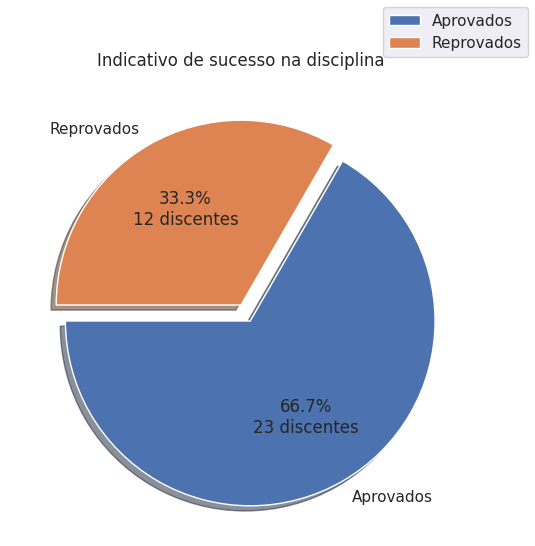

In [253]:
fig, ax = plt.subplots(figsize=(6,6))

semestre = widget_0.value # capturar semestre escolhido
disciplinas = [widget_1.value, list(widget_2.value)[0]] # capturar docente selecionadas para análise
explode = (0.1, 0.0)
data = df_final[semestre].loc[tuple(disciplinas)][0:2]
total = df_final[semestre].loc[tuple(disciplinas)][2]
ax.pie(data, labels = ['Aprovados', 'Reprovados'], 
       shadow=True, startangle=180, explode = explode,
       autopct = lambda pct: "{:.1f}%\n{:.0f} discentes".format(pct, np.ceil(pct*np.float(total)/100)));
fig.legend()
ax.set_title('Indicativo de sucesso na disciplina');

Outra estatística interessante de visualizar são as turmas com maior taxa de reprovação. Para fazer isso a partir do dataframe obtido após o tratamento dos dados é possível simplificá-lo desfazendo a MultIndexação da seguinte forma:

In [254]:
df_extra = reset_index_dict_dataframe(df_final.copy(), semestres)

Em seguida acrescenta-se uma coluna extra ao dataframe desejado a partir da divisão dos valores das colunas **reprovados** e **total_alunos** e posterior multiplicação por 100 para obtenção do valor percentual.

In [255]:
new_column = 'percentual'
df_extra = add_column_reprovado_percent(df_extra.copy(), new_column, semestres )

O novo formato do dataframe passa a ser então:

In [256]:
print(df_extra[semestre].columns.values)

['nome' 'disciplina' 'aprovados' 'reprovados' 'total_alunos' 'percentual']


Para facilitar a obtenção dos registros com as maiores taxas de reprovação foi realizada uma ordenação em ordem decrescente tomando como referência a coluna **percentual** do dataframe da seguinte forma:

In [257]:
byColumn = 'percentual'
df_extra = sort_decre_dict_dataframe(dict_df = df_extra.copy(), col = byColumn, iterators = semestres, ascending = False)

O resultado obtido até agora com o procedimento está representado abaixo:


In [258]:
df_extra[semestre].head()

,nome,disciplina,aprovados,reprovados,total_alunos,percentual
1118,CAROLINA TODESCO,METODOLOGIA DE PESQUISA EM TURISMO,0.0,1.0,1.0,100.0
1670,EDNEY RAFAEL VIANA PINHEIRO GALVAO,TERMODINÂMICA APLICADA À ENGENHARIA DE PETRÓLEO,0.0,1.0,1.0,100.0
3490,JOSUE LINS E SILVA,ESTÁGIO SUPERVISIONADO EM CONTABILIDADE,0.0,2.0,2.0,100.0
6476,VALDEMIR PRAXEDES DA SILVA NETO,PROJETO DE PESQUISA II,0.0,1.0,1.0,100.0
1822,ELKE BEATRIZ RIEDEL,CANTO II,0.0,1.0,1.0,100.0


A partir da análise do dataframe percebe-se que as turmas com maior percentual de reprovação também possuem uma quantidade ínfima de discentes matriculados, de forma a aumentar muito o peso de uma reprovação em termos absolutos. Além disso as disciplinas de interesse para análise de viabilidade dos melhores horários para plantões de monitoria são as disciplinas mais tradicionais e que comportam vários discentes. 

Para obtenção desses dados mais interessantes, definiu-se um limite inferior de 10 discentes matriculados por disciplina para verificação da taxa de reprovação. Para isso foi realizada uma filtragem dos dados conforme o código abaixo:

In [259]:
logic_filter = {'2018.1': pd.Series(dtype=np.bool), '2018.2' : pd.Series(dtype= np.bool), '2019.1': pd.Series(dtype=np.bool), '2019.2': pd.Series(dtype= np.bool)}

for semestre in semestres:
  logic_filter[semestre] = (df_extra[semestre].total_alunos >10 ) 

df_extra = logic_filter_dict_dataframe(df_extra.copy(), logic_filter, semestres )

O resultado obtido com essa filtragem está representado abaixo:

In [260]:
df_extra[semestre].head() 


,nome,disciplina,aprovados,reprovados,total_alunos,percentual
939,BRUNO DOS SANTOS GOIS,CALCULO DIFERENCIAL E INTEGRAL I,0.0,11.0,11.0,100.000000
1834,EMANUELE ORAZI,CÁLCULO I,14.0,163.0,177.0,92.090395
5245,PAULO DANTAS SESION JUNIOR,VETORES E GEOMETRIA ANALÍTICA,17.0,196.0,213.0,92.018779
5842,RONALDO CARLOTTO BATISTA,VETORES E GEOMETRIA ANALÍTICA,12.0,108.0,120.0,90.000000
3875,LEANDRO IBIAPINA BEVILAQUA,PRÉ-CÁLCULO,28.0,174.0,202.0,86.138614


Uma forma de visualizar as disciplinas com a maior taxa de reprovação pode ser feita por meio de um gráfico de barras horizontal, no qual o comprimento de cada barra indica a porcentagem de reprovação em relação ao total de discentes com o nome da discplina ao lado. A plotagem do gráfico foi feita conforme o trecho de código abaixo:

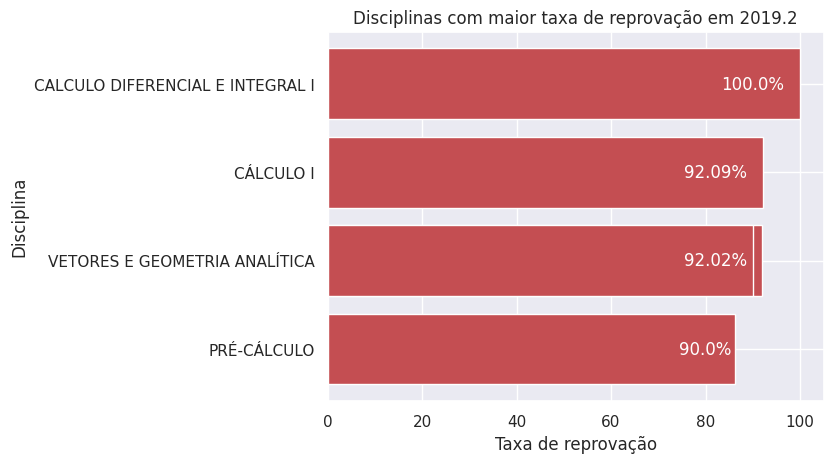

In [261]:
tam = 5
fig, ax = plt.subplots()
labels = df_extra[semestre]['disciplina'].iloc[0:tam]
data = df_extra[semestre]['percentual'].iloc[0:tam]
ax.barh(y=labels ,width= data, align='center', color = 'r')
ax.invert_yaxis()
ax.set_xlabel('Taxa de reprovação')
ax.set_ylabel('Disciplina')
ax.set_title('Disciplinas com maior taxa de reprovação em 2019.2')
rects = ax.patches
itr = 0
for rect, label in zip(rects, data):
  if(itr > tam -2):
    break
  ax.text(rect.get_x() + rect.get_width() -10 , itr, str(np.round(label,2))+'%', ha='center', va='center', color='white')
  itr += 1   
plt.show()

## 4.2. Procedimento de seleção de horários para monitoria

### 4.2.1. Tratamento e limpeza dos dados

A primeira parte da limpeza e imediatamente após a importação é filtrar as colunas para o *dataframe* comportar apenas àquelas necessárias para a análise.

A coluna **siape** deve possuir apenas valores válidos. No caso de valor *NaN*, estes não podem ser imputados, pois são de origem única e não interpoláveis, portando estes serão descartados com o método **.dropna** do Pandas.

Outra limpeza necessária é remover os discentes que aparecem triplicados em cada matéria a qual ele está matriculado. Isso pois o *dataset* de matrículas mantém registros em linhas para cada unidade do discente.

Como mais a frente serão contabilizados os horários das disciplinas, a coluna **descricao_horario** deve possuir apenas valores válidos. No caso de valor *NaN*, estes não podem ser imputados, pois são de origem única e não interpoláveis, portando estes serão descartados com o método **.dropna** do Pandas.

In [262]:
df_turmas['2018.1'] = load_dataframe('turmas-2018.1.csv')
df_turmas['2018.2'] = load_dataframe('turmas-2018.2.csv')
df_turmas['2019.1'] = load_dataframe('turmas-2019.1.csv')
df_turmas['2019.2'] = load_dataframe('turmas-2019.2.csv')
df_componentes = load_dataframe('componentes-curriculares-presenciais.csv')

In [263]:
semestres = list(df_turmas.keys())
colunas_turmas = ['id_turma', 'id_componente_curricular', 'descricao_horario']
colunas_componentes = ['id_componente', 'unidade_responsavel', 'nome']

for semestre in semestres:
  df_turmas[semestre] = df_turmas[semestre].filter(colunas_turmas).reset_index() # manter colunas essenciais
  df_turmas[semestre] = df_turmas[semestre].dropna(subset=['descricao_horario']) # descricao_horario deve ser não nula, qualquer entrada NaN deve ser descartada                   


### 4.2.2. Análise dos dados

A etapa da análise de dados pode ser dividida em alguns tópicos, estes são:

1. Identificar quais **componentes curriculares** possuem **turmas abertas** em cada semestre;
2. Realizar a escolha das **disciplinas** que terão o melhor horário para monitoria definido;
3. Localizar todos os discentes matriculados nessas turmas e todas as turmas que os discentes estão matriculados; 
4. Contabilizar melhores horários para monitoria com base nos horários com maior probabilidade dos discentes estarem livres. 



#### 4.2.2.1. Componentes curriculares com turmas abertas

As componentes curriculares com turmas ativas serão aquelas do *dataframe* das **Componentes Curriculares Presenciais** que possuem a coluna **id_componente** igual a coluna **id_componente_curricular** dos *dataframes* de **Turmas**. 

Assim será incorporado aos *dataframes* **Turmas** as colunas adicionais **nome** e **unidade_responsavel**, permitindo a correta identificação de cada turma. Para isso será utilizado um *inner merge* entre os *dataframes* supracitados com base nas colunas que possuem o ID da componente curricular. 

Após a mesclagem a coluna de **id_componente** não terá mais utilidade, podendo assim ser descartada. 

Ao final da célula há um exemplo de como um dos *dataframes* ficaram.

In [264]:
columns_to_drop = ['id_componente_curricular', 'id_componente']
for semestre in semestres: 
  df_turmas[semestre] = pd.merge(df_turmas[semestre], df_componentes, 
                                 how='inner', left_on='id_componente_curricular',
                                 right_on='id_componente').drop(columns_to_drop, axis=1) # nomeando turmas com base na sua ID de componente curricular
  df_turmas[semestre] = df_turmas[semestre].rename(columns= {'nome': 'disciplina'}, inplace=False) # renomear coluna para que fique claro o nome da disciplina
 

#### 4.2.2.2. Escolha das disciplinas a serem analisadas

A escolha da disciplina se dará por meio de **Widgets** da biblioteca *ipywidgets*. Estes permitirão que a unidade responsável pela turma seja selecionada, assim reduzindo a quantidade de escolhas de disciplinas.

A análise de agora em diante deve ser feita por semestres. Portanto haverá um widget para definir o semestre de escolha entre os semestres disponíveis.

In [265]:
def escolha_semestre_eventhandler(change):
    semestre = widget_0.value
    widget_1.options = df_turmas[semestre]['unidade_responsavel'].sort_values().unique()
def unidade_responsavel_eventhandler(change):
    semestre = widget_0.value
    widget_2.options = df_turmas[semestre]['disciplina'][df_turmas[semestre]['unidade_responsavel']==widget_1.value].sort_values().unique()
def disciplinas_eventhandler(change):
    if change['type'] == 'change' and change['name'] == 'value':
        for elem in change['new']:
            if elem not in disciplinas:
                disciplinas.append(elem)
        for elem in disciplinas:
            if elem not in change['new']:
                disciplinas.remove(elem)

disciplinas = []

widget_0 = widgets.Dropdown(options = semestres, description = 'Semestre: ', layout=widgets.Layout(width='200px'))
widget_1 = widgets.Dropdown(options = [], description = 'Unidade: ', layout=widgets.Layout(width='400px'))
widget_2 = widgets.SelectMultiple(options = [], description = 'Disciplina: ', layout=widgets.Layout(width='600px', height='300px'))

widget_0.observe(escolha_semestre_eventhandler, names='value')
widget_1.observe(unidade_responsavel_eventhandler, names='value')
widget_2.observe(disciplinas_eventhandler)

display(widgets.HTML(value = f"<b><font color='black'><font size=5>{'Escolha as disciplinas para análise'}</b>"))
widgets.HBox([ widget_0, widget_1, widget_2])

HTML(value="<b><font color='black'><font size=5>Escolha as disciplinas para análise</b>")

A célula abaixo permitirá salvar os valores importantes escolhidos nos *widgets* anteriores. Portanto, estes serão o **semestre** em análise e uma lista de **disciplinas** que consistem na componente curricular candidata a classificação do melhor horário de monitoria.

In [266]:
semestre = widget_0.value # capturar semestre escolhido
disciplinas = list(widget_2.value) # capturar disciplinas selecionadas para análise

#### 4.2.2.3. Localizar discentes matriculados nas disciplinas selecionadas

Após escolher a/as disciplina/as de interesse, o próximo passo é identificar quantos e quais discentes estão matriculados nelas. 

O trecho abaixo permitirá localizar os *id_turma* de todas as turmas cujos nomes coincidam com os nomes das disciplinas selecionadas:

```
id_turmas_selecionadas = list(df_turmas[semestre][df_turmas[semestre]['nome'].isin(disciplinas)]['id_turma'])
```

Em seguida os discentes que estão matriculados nessas turmas serão listados (extraindo valores únicos). Estes discentes serão fundamentais para a análise, pois será a partir das turmas que eles estão matriculados que será levantada uma taxa de ocupação dos horários.

```
discentes_selecionados = df_matriculas[semestre][df_matriculas[semestre]['id_turma'].isin(id_turmas_selecionadas)]['discente'].unique() 
```

Por fim os identificadores de todas as turmas cujos discentes selecionados estão matriculados serão listadas (extraindo valores únicos). Juntamente com a identificação das turmas, também será levantado um peso para cada turma que indica quantos dos discentes anteriormente escolhidos estão matriculados. 


```
turmas_discentes_selecionados = df_matriculas[semestre][df_matriculas[semestre]['discente'].isin(discentes_selecionados)].drop(columns=['index']).drop_duplicates().groupby(['id_turma'])['discente'].describe()[['count']].reset_index()
```



In [267]:
id_turmas_selecionadas = list(df_turmas[semestre][df_turmas[semestre]['disciplina'].isin(disciplinas)]['id_turma']) # id das turmas referentes às disciplinas selecionadas
discentes_selecionados = df_matriculas[semestre][df_matriculas[semestre].id_turma.isin(id_turmas_selecionadas)]['discente'].unique() # discentes que estão matriculados nas turmas buscadas
total_discentes_selecionados = discentes_selecionados.size # quantidade de discentes_selecionados 
turmas_discentes_selecionados = df_matriculas[semestre][df_matriculas[semestre]['discente'].isin(discentes_selecionados)].drop_duplicates().groupby(['id_turma'])['discente'].describe()[['count']].reset_index() # todas as turmas que os discentes selecionados estão matriculados
turmas_discentes_selecionados[turmas_discentes_selecionados['count']>=10]

,id_turma,count
0,57643608,29
3,57643653,18
4,57643654,19
5,57643655,25
27,57644662,29
...,...,...
250,57650237,16
251,57650246,15
252,57650247,10
257,57650452,21


#### 4.2.2.4. Filtrar os melhores horários para a monitoria

Uma vez que os identificadores de todas as turmas que os discentes estão matriculados estão acessíveis, basta filtrar o *dataframe* de **Turmas** para encontrar os horários dessas disciplinas.

Assim permitirá que dado o horário da turma multiplicado pelo peso da quantidade de discentes da disciplina escolhida para monitoria, seja identificada uma taxa de ocupação dos horários pelos discentes escolhidos.

OBS: A coluna **id_turma** foi descartada, pois esta não é mais necessária para análise. 

In [268]:
horarios = df_turmas[semestre][df_turmas[semestre]['id_turma'].isin(turmas_discentes_selecionados['id_turma'])][['descricao_horario','id_turma']].reset_index()
horarios = horarios.join(turmas_discentes_selecionados.set_index('id_turma'),on='id_turma').drop(columns=['index', 'id_turma']).rename(columns={"count": "peso"})
horarios.head()

,descricao_horario,peso
0,35M12,29
1,35T56,29
2,46N12,30
3,35M456,8
4,4M56 6M3456,1


Apesar dos horários estarem listados, o formato padrão definido pela UFRN não favorece a presente análise. Portanto foi desenvolvida uma API para converter os horários fornecidos pela UFRN, para uma matriz.

A imagem abaixo mostra como os horários são dispostos em um dia:

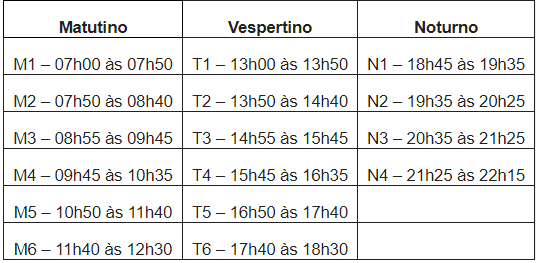

Se considerar que estes horários se repetem de segunda à sábado, pode-se definir uma matriz com 16 linhas (6 horários da manhã, 6 horários da tarde e 4 horários da noite) e 6 colunas (segunda, terça, quarta, quinta, sexta e sábado).

Primeiro tem-se que se entender como os horários estão dispostos, abaixo alguns exemplos: 

- 7M12345  
- 4T456 (22/07/2019 - 07/12/2019)
- 6T23456 7T123456  6N12345

No exemplos acima o primeiro caso se refere a uma disciplina ministrada no sábado (7) pela manhã (M) nos cinco primeiros horários (12345). Esse será o formato padrão para conversão.

O outro exemplo segue um formato parecido, porém com uma data: (22/07/2019 - 07/12/2019). Não há utilidade para essa data, portanto será usado *regex* para remover qualquer *string* entre os parenthesis.

O último exemplo é uma disciplina com horários divididos em três strings. Estas devem ser divididas e aplicadas o mesmo algoritmo que no primeiro caso, porém iterando as três vezes.

O trecho abaixo implementa a total conversão dos horários no formato oferecido pela UFRN em um formato mais adequado para a análise de dados.

In [269]:
def map_period_tuple(tuple_, array_):
  # first index:  day of the week - {'2':0, '3':1, '4':2, '5':3, '6':4, '7':5}
  # second index: shift           - {'M':M, 'T':A, 'N':N}
  # third index:  hour            - {'1':0, '2':1, '3':2, '4':3, '5':4, '6':5}
  list_days = []
  list_hours = []
  dict_shift = {'M':0, 'T':6, 'N':12} # deslocadores da linha
  [list_days.append(int(x)-2) for x in tuple_[0]] # -2 para converter do formato 234567 para 012345
  [list_hours.append(int(x)-1) for x in tuple_[2]] # -1 para converter do formato 123456 para 012345

  for i in list_hours: # linhas com base nos horários
    for j in list_days: # colunas com base nos dias da semana
      try: array_[i+dict_shift[tuple_[1]]][j] = True # preencher matriz onde foi identificado um horário
      except: pass
  return array_

def extract_numeric_period(list_):
  M = np.zeros((6,6), dtype=np.int) # morning
  A = np.zeros((6,6), dtype=np.int) # afternoon
  N = np.zeros((4,6), dtype=np.int) # night
  array_ = np.concatenate((M,A,N), axis=0)
  for str_ in list_: # iterando sobre todos os horários disponíveis, e.g: [6T23456, 7T123456, 6N12345]
    match = re.match(r"([0-9]+)([a-z]+)([0-9]+)", str_, re.I) # identificar padrão da string NúmeroLetraNúmero, separando 6T23456 em (6, T, 23456)
    if match: array_ = map_period_tuple(match.groups(), array_) # se identificar padrão anterior, deverá converte-lo em matriz
  return array_

horarios_modificando = horarios['descricao_horario'].str.replace("[(@*&?].*[)@*&?]", "", regex=True) # remover conteúdo entre parenthesis das strings e.g: 4T456 (22/07/2019 - 07/12/2019) -> 4T456 
horarios_listas = horarios_modificando.str.split(' ').dropna() # dividir string '6T23456 7T123456 6N12345' em lista [6T23456, 7T123456, 6N12345]
horarios_matrix = horarios_listas.apply(extract_numeric_period) # aplicar conversão de horário formato UFRN para matriz
horarios_matrix_pesos = horarios_matrix*horarios['peso'] # aplicando os pesos aos horários existentes

Finalmente o objeto *Series* armazenado em:

```
horarios_matrix_pesos
```

Armazena todas as matrizes dos horários ponderada pelos pesos escolhidos. Somando todas essas matrizes de mesma dimensão, consegue-se uma boa estimativa da taxa de ocupação dos horários dos discentes escolhidos, permitindo selecionar o horário da monitoria em momentos que haverá uma maior probabilidade de discentes que necessitam da monitoria não haverem aula.



Assim, na célula abaixo são calculados dois indicadores, que basicamente indicam a mesma coisa, um é:

```
piores_horarios_monitoria
```

Que representa a quantidade de discentes que frequentam as disciplinas escolhidas que estão atarefados com aula.

Já o indicador:


```
melhores_horarios_monitoria
```

É o complementar do anterior, pois ele subtrai do total dos discentes que  frequentam disciplinas escolhidas os horários para cada dia, resultando em uma indicativa de quais horários possuem maior probabilidade dos discentes estarem vagos.


In [270]:
total_discentes_selecionados = np.max(piores_horarios_monitoria)
piores_horarios_monitoria = horarios_matrix_pesos.sum() # quanto maior o valor, mais discentes (dos escolhidos) estão ocupados
melhores_horarios_monitoria = total_discentes_selecionados-piores_horarios_monitoria # quanto maior o valor, mais discentes (dos escolhidos) estão desocupados

### 4.2.3. Visualização dos resultados

A melhor forma de observar os resultados é por meio de um *heatmap* destacando o calendário dos horários durante a semana e plotando o resultado final.

In [271]:
labels_dia_semana = ['SEG','TER','QUA','QUI','SEX','SAB','']
labels_horario = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 
                  'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 
                  'N1', 'N2', 'N3', 'N4']

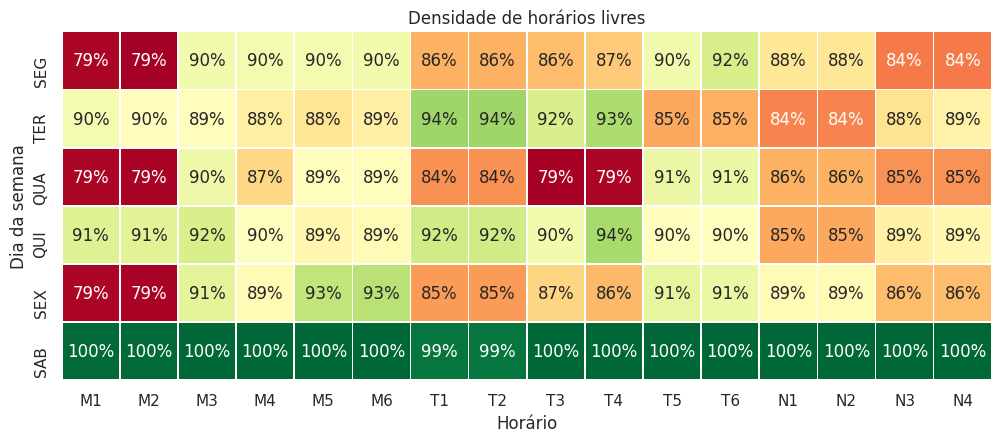

In [272]:
sns.set(font_scale=1)
f, heatmap = plt.subplots(figsize=(12, 32))
heatmap = sns.heatmap(np.transpose(melhores_horarios_monitoria)/total_discentes_selecionados, annot=True, fmt=".0%", linewidths=.5, cmap="RdYlGn", cbar=False, square=True)
heatmap.set_yticklabels(labels_dia_semana) 
heatmap.set_xticklabels(labels_horario)
plt.ylabel("Dia da semana")
plt.xlabel("Horário") 
plt.title("Densidade de horários livres");

Em alguns casos torna-se melhor excluir o sábado da visualização, pois este é um horário que geralmente não há aula presencial e não é tão recomendado para plantões de monitoria (apesar de existirem em casos excepcionais).

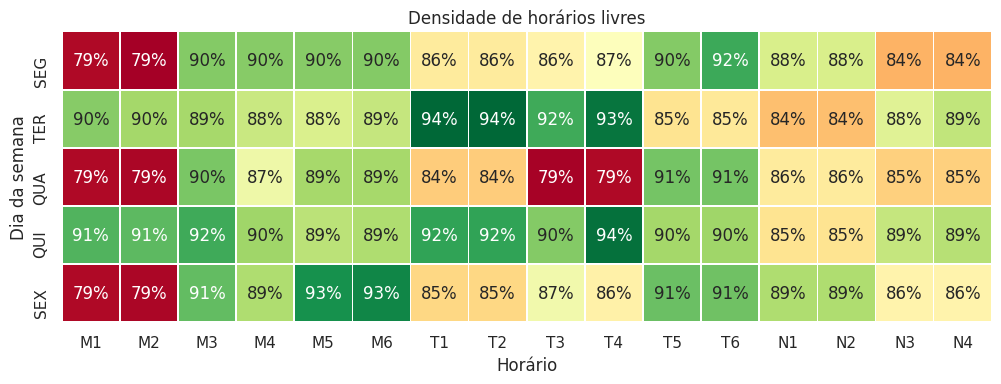

In [273]:
sns.set(font_scale=1)
f, heatmap = plt.subplots(figsize=(12, 32))
heatmap = sns.heatmap(np.transpose(melhores_horarios_monitoria)[:-1]/total_discentes_selecionados, annot=True, fmt=".0%", linewidths=.5, cmap="RdYlGn", cbar=False, square=True)
heatmap.set_yticklabels(labels_dia_semana[:-1]) 
heatmap.set_xticklabels(labels_horario)
plt.ylabel("Dia da semana")
plt.xlabel("Horário") 
plt.title("Densidade de horários livres");

Ainda assim, em meio a tantos horários livres e com passe livre para habilitar plantões de monitoria, resta uma decisão final. Esta decisão pode ser norteada por um gráfico de barras horizontal, que indica uma quantidade $n$ dos melhores horários para plantões.

Mas antes disso, a representação por matrizes dos horários deverá ser convertida para a representação original por meio da célula abaixo.

In [274]:
def coordinates_to_horary(x,y):
  day = 0
  shift = 'A'
  hour = 0
  if(y>=0 and y<=5): day = y+2
  if(x>=0 and x<=5): # M
    shift = 'M'
    hour = x+1
  elif(x>=6 and x<=11): # T
    shift = 'T'
    hour = x+1-6
  elif(x>=12 and x<=15): # N
    shift = 'N'
    hour = x+1-12
  return str(day) + shift + str(hour)

rows, columns = np.unravel_index(np.argsort(melhores_horarios_monitoria, axis=None), melhores_horarios_monitoria.shape)
ocorrencia_por_horario = {}
for x,y in zip(rows,columns): # vasculha todas as posições da matriz final, obtendo densidade de horarios para cada horario do dia e semana
  if(y!=5): # exclui do ranking o SÁBADO
    ocorrencia_por_horario[coordinates_to_horary(x,y)] = melhores_horarios_monitoria[x,y]  
ranqueado = sorted(ocorrencia_por_horario.items(), key=lambda x: x[1], reverse=True)

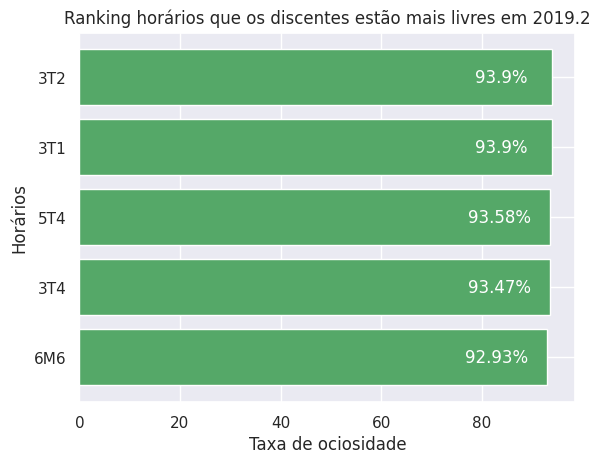

In [292]:
numero_de_horarios = 5
labels = []
data = []
for itr in range(numero_de_horarios): 
  labels.append(ranqueado[itr][0])
  data.append(100*ranqueado[itr][1]/total_discentes_selecionados)

fig, ax = plt.subplots()
ax.barh(y=labels, width=data, align='center', color = 'g')
ax.invert_yaxis()
ax.set_xlabel('Taxa de ociosidade')
ax.set_ylabel('Horários')
ax.set_title('Ranking horários que os discentes estão mais livres em '+ str(semestre))
rects = ax.patches
itr = 0
for rect, label in zip(rects, data):
  if(itr > numero_de_horarios -1):
    break
  ax.text(rect.get_x() + rect.get_width() -10 , itr, str(np.round(label,2))+'%', ha='center', va='center', color='white')
  itr += 1   
plt.show()

O plot seguinte consistirá em um gráfico de pizza que apresentará os dias da semana que possuem menos discentes matriculados. Os dados foram obtidos somando os resultados do *heatmep* no eixo do dias, assim obtendo quantos horários livres existem no dado dia. O resultado final destacará o dia com maior porcentagem de horários livres, assim permitindo ter uma noção de que dia estes discentes estão mais livres.

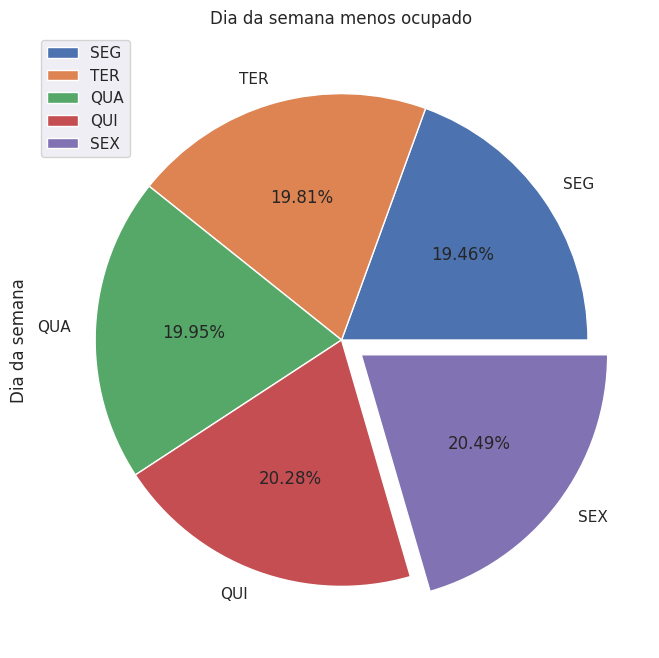

In [293]:
melhor_dia_da_semana = np.sort(np.sum(melhores_horarios_monitoria, axis=0)[:-1])
explode = np.zeros(5)
explode[-1] += 0.1 
df_pie = pd.DataFrame({'dia_mais_ocupado': melhor_dia_da_semana/np.sum(melhor_dia_da_semana)}, index= ['SEG','TER','QUA','QUI','SEX'])
plot = df_pie.plot.pie(y='dia_mais_ocupado', figsize=(8, 8), autopct='%1.2lf%%', explode=explode)
plt.title('Dia da semana menos ocupado')
plt.ylabel('Dia da semana');

# 5. Conclusões

Apesar dos resultados mostrarem um impacto visual imediato, o sucesso da análise está diretamente atrelado à sua implementação prática.

Portanto os próximos passos consistem em apresentar essa análise exploratória desses dados para gestores de forma que direcionamentos possam ser tomados e os resultados sejam testados na prática.

Apesar da robustez do procedimento de análise, este ainda está refém ao conjunto de dados alimentado. Por isso deve-se evitar utilizar *datasets* demasiadamente antigos.

Também deve-se manter atento à paridade do semestre em análise. Resultados de um semestre ímpar, estão mais aptos a contribuírem para bons resultados práticos se implementados em semestre ímpares e vice-versa para os pares. Garantindo o respeito ao rodízio de turmas que comumente é realizado entre semestres.

Os próximos passos que podem ser tomados em relação ao trabalho é voltar a atenção aos semestres que houveram aulas remotas. Porém, a análise será tão objetiva se a modalidade remota for perdurar.

O desenvolvimento de uma interface Web para a acessar a análise exploratória é um passo seguinte essencial, pois esta permitirá a desassociação entre o usuário e o código, permitindo que a ferramenta seja utilizada em grande escala e por usuários leigos ao estilo de programação utilizada neste trabalho.